
=== MERGED TRAIN STATS ===

Summary:
 Total images  Labeled images  Total objects
         2496            2228           4185

Class distribution:
 Class ID    Class name  Count Percent
        0       tweezer   1964  46.93%
        1 needle holder   2221  53.07%

Visible keypoints:
 Keypoint index  Visible count Percent
              1           4185  20.00%
              2           4185  20.00%
              3           4185  20.00%
              4           4185  20.00%
              5           4185  20.00%

Image size stats:
 Width_mean  Width_median  Width_min  Width_max  Height_mean  Height_median  Height_min  Height_max
      960.0         960.0        960        960        544.0          544.0         544         544


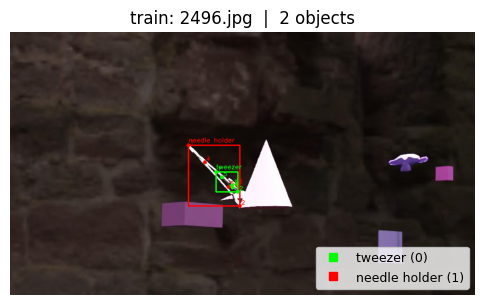

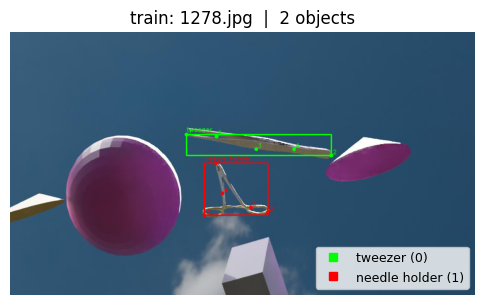

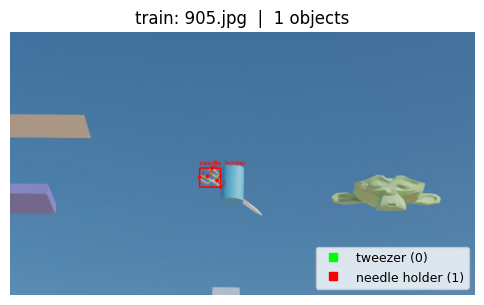

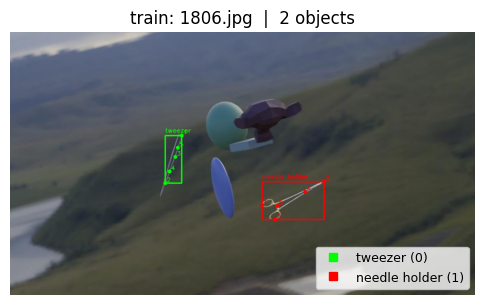


=== MERGED VAL STATS ===

Summary:
 Total images  Labeled images  Total objects
         1428            1264           2369

Class distribution:
 Class ID    Class name  Count Percent
        0       tweezer   1109  46.81%
        1 needle holder   1260  53.19%

Visible keypoints:
 Keypoint index  Visible count Percent
              1           2369  20.00%
              2           2369  20.00%
              3           2369  20.00%
              4           2369  20.00%
              5           2369  20.00%

Image size stats:
 Width_mean  Width_median  Width_min  Width_max  Height_mean  Height_median  Height_min  Height_max
      960.0         960.0        960        960        544.0          544.0         544         544


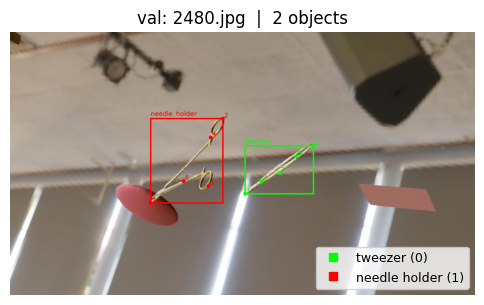

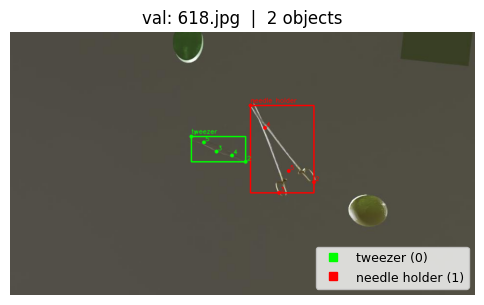

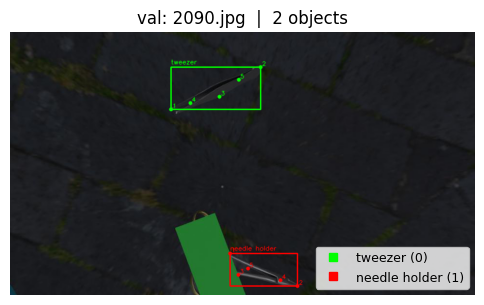

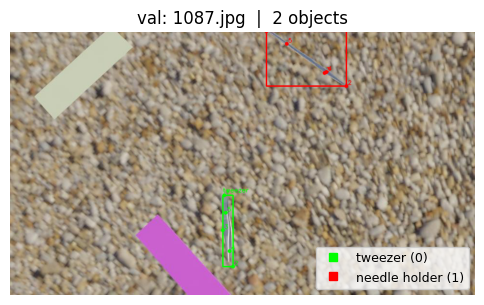

In [ ]:
#!/usr/bin/env python3
import os
import random
import glob
from collections import Counter, defaultdict
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------- configuration --------
DATA_ROOTS = [
    "/home/student/SYNTH_DATA/train_val_split",
    
]
SPLITS = ["train", "val"]
NUM_SHOW = 4
SEED = 434

# class mapping
CLASS_NAMES = {
    0: "tweezer",
    1: "needle holder",
}

CLASS_COLORS = {
    0: (0, 255, 0),   # tweezer  green
    1: (0, 0, 255),   # needle holder  red
}

# --------------------------------

random.seed(SEED)
np.random.seed(SEED)

def list_items(split_root):
    img_dir = os.path.join(split_root, "images")
    lbl_dir = os.path.join(split_root, "labels")
    imgs = sorted(glob.glob(os.path.join(img_dir, "*.*")))
    pairs = []
    for img_path in imgs:
        stem = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, f"{stem}.txt")
        pairs.append((img_path, lbl_path if os.path.exists(lbl_path) else None))
    return pairs

def parse_yolo_pose_label(label_path):
    objects = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 20:
                continue
            cls = int(parts[0])
            xc, yc, w, h = map(float, parts[1:5])
            kps = list(map(float, parts[5:]))
            kp_triplets = []
            for i in range(0, len(kps), 3):
                kp_triplets.append((kps[i], kps[i+1], int(kps[i+2])))
            objects.append({"cls": cls, "bbox": (xc, yc, w, h), "kps": kp_triplets})
    return objects

def denorm_bbox(bbox, W, H):
    xc, yc, w, h = bbox
    x = (xc - w/2.0) * W
    y = (yc - h/2.0) * H
    return int(round(x)), int(round(y)), int(round(w * W)), int(round(h * H))

def denorm_kps(kps, W, H):
    return [(int(round(x * W)), int(round(y * H)), v) for x, y, v in kps]

def draw_labels(img_bgr, objects, class_colors=None, thickness=2):
    out = img_bgr.copy()
    H, W = out.shape[:2]
    if class_colors is None:
        class_colors = defaultdict(lambda: (0, 255, 0))
    for obj in objects:
        c = class_colors.get(obj["cls"], (255, 255, 255))
        x, y, w, h = denorm_bbox(obj["bbox"], W, H)
        cv2.rectangle(out, (x, y), (x + w, y + h), c, thickness)
        kps = denorm_kps(obj["kps"], W, H)
        for idx, (kx, ky, v) in enumerate(kps, start=1):
            cv2.circle(out, (kx, ky), 4, c, -1)
            cv2.putText(out, str(idx), (kx + 3, ky - 3),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, c, 1, cv2.LINE_AA)
        name = CLASS_NAMES.get(obj["cls"], f"class {obj['cls']}")
        cv2.putText(out, name, (x, max(0, y - 6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, c, 1, cv2.LINE_AA)
    return out

def analyze_split(pairs):
    stats = {
        "num_images": 0,
        "num_labeled_images": 0,
        "num_objects": 0,
        "classes": Counter(),
        "kp_vis_counts": Counter(),
        "img_sizes": []   
    }
    for img_path, lbl_path in pairs:
        
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            stats["img_sizes"].append((w, h))

        stats["num_images"] += 1
        if not lbl_path or not os.path.getsize(lbl_path):
            continue
        stats["num_labeled_images"] += 1
        objs = parse_yolo_pose_label(lbl_path)
        stats["num_objects"] += len(objs)
        for obj in objs:
            stats["classes"][obj["cls"]] += 1
            for idx, (_, _, v) in enumerate(obj["kps"], start=1):
                if v > 0:
                    stats["kp_vis_counts"][idx] += 1
    return stats


def print_stats(split_name, stats):
    print(f"\n=== MERGED {split_name.upper()} STATS ===")

 
    summary_df = pd.DataFrame([{
        "Total images": stats['num_images'],
        "Labeled images": stats['num_labeled_images'],
        "Total objects": stats['num_objects'],
    }])
    print("\nSummary:")
    print(summary_df.to_string(index=False))

    # ---- חלוקת מחלקות ----
    if stats["classes"]:
        total_objs = sum(stats["classes"].values())
        class_rows = []
        for cls, cnt in sorted(stats["classes"].items()):
            class_rows.append({
                "Class ID": cls,
                "Class name": CLASS_NAMES.get(cls, f"class {cls}"),
                "Count": cnt,
                "Percent": f"{(cnt/total_objs)*100:.2f}%"
            })
        class_df = pd.DataFrame(class_rows)
        print("\nClass distribution:")
        print(class_df.to_string(index=False))


    if stats["kp_vis_counts"]:
        total_kps = sum(stats["kp_vis_counts"].values())
        kp_rows = []
        for idx in range(1, 6):
            cnt = stats["kp_vis_counts"].get(idx, 0)
            pct = (cnt / total_kps * 100) if total_kps > 0 else 0
            kp_rows.append({
                "Keypoint index": idx,
                "Visible count": cnt,
                "Percent": f"{pct:.2f}%"
            })
        kp_df = pd.DataFrame(kp_rows)
        print("\nVisible keypoints:")
        print(kp_df.to_string(index=False))

   
    if stats["img_sizes"]:
        widths, heights = zip(*stats["img_sizes"])
        size_df = pd.DataFrame({
            "Width": widths,
            "Height": heights
        })
        stats_df = pd.DataFrame([{
            "Width_mean": np.mean(widths),
            "Width_median": np.median(widths),
            "Width_min": np.min(widths),
            "Width_max": np.max(widths),
            "Height_mean": np.mean(heights),
            "Height_median": np.median(heights),
            "Height_min": np.min(heights),
            "Height_max": np.max(heights),
        }])
        print("\nImage size stats:")
        print(stats_df.round(2).to_string(index=False))


def make_legend(ax):
    handles = []
    for cls, name in CLASS_NAMES.items():
        c_bgr = CLASS_COLORS.get(cls, (255, 255, 255))
        c_rgb = tuple(np.array(c_bgr) / 255.0)[::-1]
        handles.append(
            plt.Line2D([0], [0],
                       marker='s', linestyle='',
                       markerfacecolor=c_rgb, markeredgecolor=c_rgb,
                       label=f"{name} ({cls})", color=c_rgb)
        )
    ax.legend(handles=handles, loc="lower right", frameon=True, fontsize=9)

def preview_samples(split_name, pairs, num_show=5):
    labeled = [(img, lbl) for img, lbl in pairs if lbl and os.path.getsize(lbl)]
    if not labeled:
        print(f"No labeled samples to preview in {split_name}")
        return
    sample = random.sample(labeled, min(num_show, len(labeled)))
    for img_path, lbl_path in sample:
        img = cv2.imread(img_path)
        objs = parse_yolo_pose_label(lbl_path)
        vis = draw_labels(img, objs, class_colors=CLASS_COLORS)
        plt.figure(figsize=(6, 6))
        plt.title(f"{split_name}: {os.path.basename(img_path)}  |  {len(objs)} objects")
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        make_legend(plt.gca())
    plt.show()

def main():
    for split in SPLITS:
    
        all_pairs = []
        for root in DATA_ROOTS:
            split_root = os.path.join(root, split)
            if not os.path.isdir(split_root):
                continue
            all_pairs.extend(list_items(split_root))
        if not all_pairs:
            print(f"Missing split folders for {split}")
            continue
        stats = analyze_split(all_pairs)
        print_stats(split, stats)
        preview_samples(split, all_pairs, NUM_SHOW)

if __name__ == "__main__":
    main()
